In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00


In [2]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'german-credit-scoring-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4316755%2F7419868%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240727%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240727T065255Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0e441dc5f7fc512e5e82007ca406fd36c922145ed8d1966babbef21a7672e62291f5fe94e9a31959482a5c6e803e3543c4bd43c502540c4312590089dbe95c0ffe35ce374de2b40b88237fd77915b1eb4d0d52dd8f8faec8c1ecbf5b9486088cabc7bc72798149bebde2ff1620c8260bbb003cf637be11825fabb48a4f6b489b01f23c024bea1e383709287d2c93e6f39f8d7ac8a12c4a1434dc406c229d22d87310eddfe5df842e390e6ba4950806c269a5d09a0f812d69a3dbfc860739a69e784fa1fcce3984d72590f4bfc99a52c58d07a5fd7655d12018aa72bd0d2bdfd32c810a4987050cf58009743547ba1f636cd048e9515ba50207088f2cf9e467d1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 17947 bytes downloaded
Downloaded and uncompressed: german-credit-scoring-data
Data source import complete.


In [3]:
import numpy as np
import optuna

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler,\
                                    PowerTransformer, TargetEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import SelectFromModel, SelectFwe, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import sklearn.metrics as met

from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

import sklearn
sklearn.set_config(transform_output="pandas")

GLOBAL_SEED = 1

In [4]:
df = pd.read_csv('/kaggle/input/german-credit-scoring-data/german_credit_cleaned.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   checking_acc_status       1000 non-null   object
 1   duration                  1000 non-null   int64 
 2   cred_hist                 1000 non-null   object
 3   purpose                   1000 non-null   object
 4   loan_amt                  1000 non-null   int64 
 5   saving_acc_bonds          1000 non-null   object
 6   present_employment_since  1000 non-null   object
 7   installment_rate          1000 non-null   int64 
 8   personal_stat_gender      1000 non-null   object
 9   other_debtors_guarantors  1000 non-null   object
 10  present_residence_since   1000 non-null   int64 
 11  property                  1000 non-null   object
 12  age                       1000 non-null   int64 
 13  other_installment_plans   1000 non-null   object
 14  housing                  

All columns are currently assigned the 'object' data type, which occupies more memory space. Numeric columns should be represented as integers or floats, and categorical columns as 'category' types. This optimization would result in more efficient memory storage

In [6]:
numeric_features = ['duration', 'loan_amt', 'installment_rate', 'present_residence_since', 'age', 'num_curr_loans',
                    'num_people_provide_maint']
categorical_features = ['checking_acc_status', 'cred_hist', 'purpose', 'saving_acc_bonds', 'present_employment_since',
                        'personal_stat_gender', 'other_debtors_guarantors', 'property', 'other_installment_plans',
                        'housing', 'job', 'telephone', 'is_foreign_worker']

df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors='coerce', downcast='integer')
df[categorical_features] = df[categorical_features].astype('category')
df['target'] = np.where(df['target']=='good', 1, 0).astype('int8')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   checking_acc_status       1000 non-null   category
 1   duration                  1000 non-null   int8    
 2   cred_hist                 1000 non-null   category
 3   purpose                   1000 non-null   category
 4   loan_amt                  1000 non-null   int16   
 5   saving_acc_bonds          1000 non-null   category
 6   present_employment_since  1000 non-null   category
 7   installment_rate          1000 non-null   int8    
 8   personal_stat_gender      1000 non-null   category
 9   other_debtors_guarantors  1000 non-null   category
 10  present_residence_since   1000 non-null   int8    
 11  property                  1000 non-null   category
 12  age                       1000 non-null   int8    
 13  other_installment_plans   1000 non-null   categor

In [7]:
for cat in categorical_features:
    print(df[cat].value_counts(1))
    print('-----------------')

checking_acc_status
no_cheking_acc    0.394
below_0           0.274
below_200         0.269
above:200         0.063
Name: proportion, dtype: float64
-----------------
cred_hist
curr_loans_paid_duly            0.530
risky_acc_or_curr_loan_other    0.293
delay_in_past                   0.088
paid_duly_this_bank             0.049
no_loan_or_paid_duly_other      0.040
Name: proportion, dtype: float64
-----------------
purpose
radio_tv               0.280
car_new                0.234
furniture_equipment    0.181
car_used               0.103
business               0.097
education              0.050
repairs                0.022
domestic_applience     0.012
others                 0.012
retraining             0.009
Name: proportion, dtype: float64
-----------------
saving_acc_bonds
below_100                0.603
unknown_no_saving_acc    0.183
below_500                0.103
below_1000               0.063
above_1000               0.048
Name: proportion, dtype: float64
-----------------
present_em

In [8]:
df.target.value_counts(1)

target
1    0.7
0    0.3
Name: proportion, dtype: float64

In [9]:
X = df[numeric_features+categorical_features] #Independent - predictor variables
y = df['target'] # Dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=GLOBAL_SEED, stratify=y)

Train-test split is done to have unseen data in order to check real performance of the model. test_size = 0.25 depicts 25% of dataset will be used as test data, stratify=y ensures proportion of good and bads equal be same in train and test sets

Baseline Model

In [10]:
#Encode categorical features
te = TargetEncoder(random_state=GLOBAL_SEED)
X_train_encoded = te.fit_transform(X_train[categorical_features],y_train)
X_test_encoded = te.transform(X_test[categorical_features])#attention
X_train_preprocessed = pd.concat([X_train[numeric_features], X_train_encoded], axis=1)
X_test_preprocessed = pd.concat([X_test[numeric_features], X_test_encoded], axis=1)

model = LogisticRegression(penalty=None, random_state=GLOBAL_SEED)
model.fit(X_train_preprocessed, y_train)

# Predict on the test data
y_train_pred_proba = model.predict_proba(X_train_preprocessed)[:, 1]
y_pred_proba = model.predict_proba(X_test_preprocessed)[:, 1]

# Evaluate the model
train_auc = met.roc_auc_score(y_train, y_train_pred_proba)
test_auc = met.roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC on train data: {round(train_auc, 3)}")
print(f"AUC-ROC on test data: {round(test_auc, 3)}")

print(f"Gini score: {round(test_auc*2-1, 3)}")

AUC-ROC on train data: 0.712
AUC-ROC on test data: 0.705
Gini score: 0.41


In [11]:
cats = np.concatenate(te.categories_).reshape(-1,1)
ends = np.concatenate(te.encodings_).reshape(-1,1)

features = []
for feature in categorical_features:
    n_cat = df[feature].nunique()
    [features.append(feature) for i in range(n_cat)]

comb = np.concatenate((cats, ends), axis = 1)
te_df = pd.DataFrame(comb, index=features).reset_index()
te_df.columns = ['feature','category', 'encoding_value']
te_df.head()

,feature,category,encoding_value
0,checking_acc_status,above:200,0.783003
1,checking_acc_status,below_0,0.517783
2,checking_acc_status,below_200,0.611332
3,checking_acc_status,no_cheking_acc,0.881219
4,cred_hist,curr_loans_paid_duly,0.676906


Encoding values for purpose and employement

In [12]:
te_df[te_df.feature.isin(['present_employment_since', 'purpose'])]

,feature,category,encoding_value
9,purpose,business,0.62774
10,purpose,car_new,0.626822
11,purpose,car_used,0.868949
12,purpose,domestic_applience,0.610256
13,purpose,education,0.580854
14,purpose,furniture_equipment,0.676873
15,purpose,others,0.572246
16,purpose,radio_tv,0.777456
17,purpose,repairs,0.668863
18,purpose,retraining,1.0


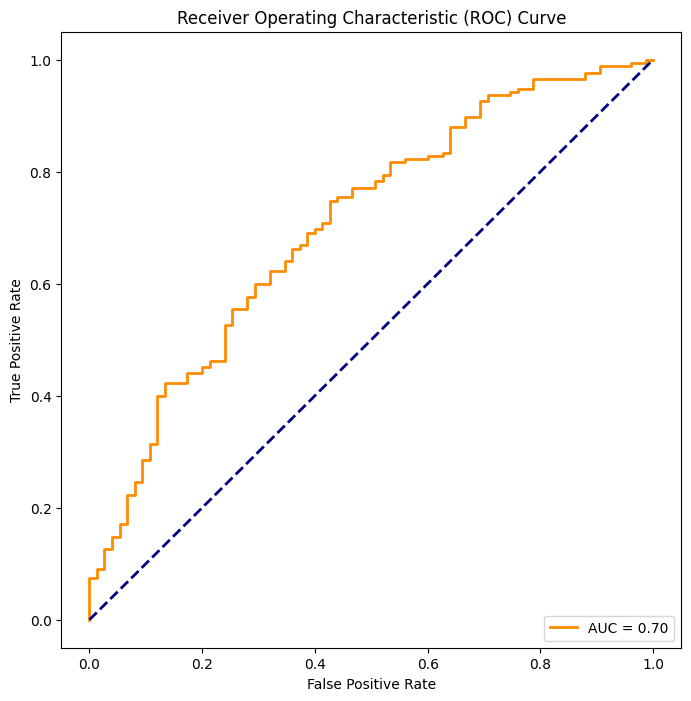

In [13]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = met.roc_curve(y_test, y_pred_proba)
roc_auc = met.auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [14]:
numeric_features = X.select_dtypes(exclude='category').columns
purpose = ['purpose']
other_categorical_features = X.drop('purpose', axis=1).select_dtypes('category').columns

 Hyperparameter tuning with Optuna

In [15]:
class LogOddsEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, smoothing_factor=1):
        self.feature_log_odds = {}
        self.smoothing_factor = smoothing_factor

    def fit(self, X, y=None):
        for column in X.columns:
            # Calculate log odds for each category in the column
            Xy = pd.concat([X,y], axis=1)
            events = Xy.groupby(column)['target'].mean()
            category_log_odds = np.log((events + self.smoothing_factor) /
                                       (Xy['target'].mean() + 2 * self.smoothing_factor))

            self.feature_log_odds[column] = category_log_odds.to_dict()

        return self

    def transform(self, X, y=None):
        X_encoded = X.copy()
        for column in X.columns:
            # Replace original categories with log odds in the transformed data
            X_encoded[column] = X[column].map(self.feature_log_odds[column])
        return X_encoded

    def get_feature_names_out():
        pass


Tuned parameters

In [16]:
def objective(trial):

    """ 'objective'that takes hyperparameters as input and returns a score to be minimized """

    params = {
        'class_weight':'balanced',
        'C': trial.suggest_float("C", 1e-3, 1000),
        'l1_ratio': trial.suggest_float("l1_ratio", 0, 1),
        'penalty':'elasticnet',
        'solver': 'saga',
        'random_state': GLOBAL_SEED
    }

    min_frequency = trial.suggest_categorical("min_frequency", [0.01, 0.012, 0.015, 0.020, 0.052])
    smoothing = trial.suggest_float("smoothing", 1e-4, 10) # for
    multiplier = trial.suggest_float("multiplier", 0, 1) # for SelectFromModel

    scaler_options = {
        'StandardScaler': StandardScaler(),
        'RobustScaler': RobustScaler(),
        'MinMaxScaler': MinMaxScaler(feature_range=(-1,1))
    }

    cat_encoding_options = {
        'ohe': OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary'),
        'target_encoder': TargetEncoder(random_state=GLOBAL_SEED),
        'lg_encoder': LogOddsEncoder(smoothing)
    }

    purpose_encoding_options = {
        'ohe': OneHotEncoder(min_frequency=min_frequency, sparse_output=False, handle_unknown='ignore'),
        'target_encoder': TargetEncoder(random_state=GLOBAL_SEED),
        'lg_encoder': LogOddsEncoder(smoothing)
    }

    selected_scaler = trial.suggest_categorical("scaler", ['StandardScaler','RobustScaler', 'MinMaxScaler'])
    selected_cat_encoder = trial.suggest_categorical('cat_encoder', ['ohe', 'target_encoder', 'lg_encoder'])
    selected_purpose_encoder = trial.suggest_categorical('purpose_encoder', ['target_encoder', 'lg_encoder'])

    model = LogisticRegression(**params)

    num_p = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                          ('scaler', scaler_options[selected_scaler])])

    if selected_cat_encoder == 'ohe':

        other_cat_p = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='not_given')),
                 ('encoder', cat_encoding_options[selected_cat_encoder])])
    else:

        other_cat_p = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='not_given')),
                        ('encoder', cat_encoding_options[selected_cat_encoder]),
                                     ('scaler', scaler_options[selected_scaler])])

    if selected_purpose_encoder == 'ohe':

        purpose_p = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='not_given')),
                        ('encoder', purpose_encoding_options[selected_purpose_encoder])])
    else:

        purpose_p = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='not_given')),
                        ('encoder', purpose_encoding_options[selected_purpose_encoder]),
                                   ('scaler', scaler_options[selected_scaler])])

    transformer = ColumnTransformer(transformers=[
        ('num_p', num_p, numeric_features),
        ('other_cat_p', other_cat_p, other_categorical_features),
        ('purpose_p', purpose_p, purpose)
    ])#.set_output(transform='pandas')


    # Full Pipeline
    pipeline = Pipeline(steps=[
        ('transformer', transformer),
        ('selector', SelectFromModel(model,threshold=f'{multiplier}*median', max_features=None)),
        ('model', model)
    ])#.set_output(transform='pandas')

    means = cross_val_score(estimator=pipeline,X=X_train,y=y_train, cv=10, scoring='roc_auc')

    return np.mean(means)

In [19]:
def tune(objective):
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(
                            seed=GLOBAL_SEED))
    study.optimize(objective, n_trials=100, show_progress_bar=True)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return study

In [20]:
study = tune(objective)

[I 2024-07-27 09:07:04,618] A new study created in memory with name: no-name-0b4fd711-ec92-4158-9325-b37f18cef2f8


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-27 09:07:05,660] Trial 0 finished with value: 0.767593378729556 and parameters: {'C': 417.0225876805693, 'l1_ratio': 0.7203244934421581, 'min_frequency': 0.012, 'smoothing': 3.4556727143577732, 'multiplier': 0.39676747423066994, 'scaler': 'MinMaxScaler', 'cat_encoder': 'target_encoder', 'purpose_encoder': 'target_encoder'}. Best is trial 0 with value: 0.767593378729556.
[I 2024-07-27 09:07:06,897] Trial 1 finished with value: 0.7658264827871062 and parameters: {'C': 558.6902697559232, 'l1_ratio': 0.14038693859523377, 'min_frequency': 0.015, 'smoothing': 8.763903884045153, 'multiplier': 0.8946066635038473, 'scaler': 'MinMaxScaler', 'cat_encoder': 'ohe', 'purpose_encoder': 'target_encoder'}. Best is trial 0 with value: 0.767593378729556.
[I 2024-07-27 09:07:08,945] Trial 2 finished with value: 0.7604900841570241 and parameters: {'C': 691.8774220733594, 'l1_ratio': 0.31551563100606295, 'min_frequency': 0.052, 'smoothing': 7.481681727232956, 'multiplier': 0.2804439920644052, 'sc

In [21]:
params = study.best_params
params

{'C': 85.08441326427396,
 'l1_ratio': 0.06359193560684012,
 'min_frequency': 0.02,
 'smoothing': 3.9495914342492124,
 'multiplier': 0.7872054898640072,
 'scaler': 'MinMaxScaler',
 'cat_encoder': 'lg_encoder',
 'purpose_encoder': 'target_encoder'}

In [22]:
model_params = {
    'class_weight': 'balanced',
    'C': params['C'],
    'l1_ratio': params['l1_ratio'],
    'penalty': 'elasticnet',
    'solver': 'saga',
    'random_state': GLOBAL_SEED
}

scaler_options = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'MinMaxScaler': MinMaxScaler(feature_range=(-1,1))
}

cat_encoding_options = {
    'ohe': OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary'),
    'target_encoder': TargetEncoder(random_state=GLOBAL_SEED),
    'lg_encoder': LogOddsEncoder(params['smoothing'])
}

purpose_encoding_options = {
    'ohe': OneHotEncoder(min_frequency=params['min_frequency'], sparse_output=False, handle_unknown='ignore'),
    'target_encoder': TargetEncoder(random_state=GLOBAL_SEED),
    'lg_encoder': LogOddsEncoder(params['smoothing'])
}


model = LogisticRegression(**model_params)

num_p = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                      ('scaler', scaler_options[params['scaler']])])

if params['cat_encoder'] == 'ohe':
  other_cat_p = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='not_given')),
             ('encoder', cat_encoding_options[selected_cat_encoder])])
else:

    other_cat_p = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='not_given')),
                    ('encoder', cat_encoding_options[params['cat_encoder']]),
                                 ('scaler', scaler_options[params['scaler']])])

if params['purpose_encoder'] == 'ohe':

    purpose_p = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='not_given')),
                    ('encoder', purpose_encoding_options[params['purpose_encoder']])])
else:

    purpose_p = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='not_given')),
                    ('encoder', purpose_encoding_options[params['purpose_encoder']]),
                               ('scaler', scaler_options[params['scaler']])])

transformer = ColumnTransformer(transformers=[
    ('num_p', num_p, numeric_features),
    ('other_cat_p', other_cat_p, other_categorical_features),
    ('purpose_p', purpose_p, purpose)
])


# Full Pipeline
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('selector', SelectFromModel(model, threshold=f"{params['multiplier']}*median", max_features=None)),
    ('model', model)
])



# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num_p',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   MinMaxScaler(feature_range=(-1,
                                                                                               1)))]),
                                                  Index(['duration', 'loan_amt', 'installment_rate', 'present_residence_since',
       'age', 'num_curr_loans', 'num_people_provide_maint'],
      dtype='object')),
                                                 ('other_cat_...
                 SelectFromModel(estimator=LogisticRegression(C=85.08441326427396,
                                                              class_weight='balanced',
                                                              l1_ratio=0.06359193560684012,
                                                              penalty='elasticnet',
                                                              random_state=1,
                                                              solver='saga'),
                                 threshold='0.7872054898640072*median')),
                ('model',
                 LogisticRegression(C=85.08441326427396,
                                    class_weight='balanced',
                                    l1_ratio=0.06359193560684012,
                                    penalty='elasticnet', random_state=1,
                                    solver='saga'))])

In [23]:
y_train_pred_proba = pipeline.predict_proba(X_train)[:,1]
y_pred_proba = pipeline.predict_proba(X_test)[:,1]

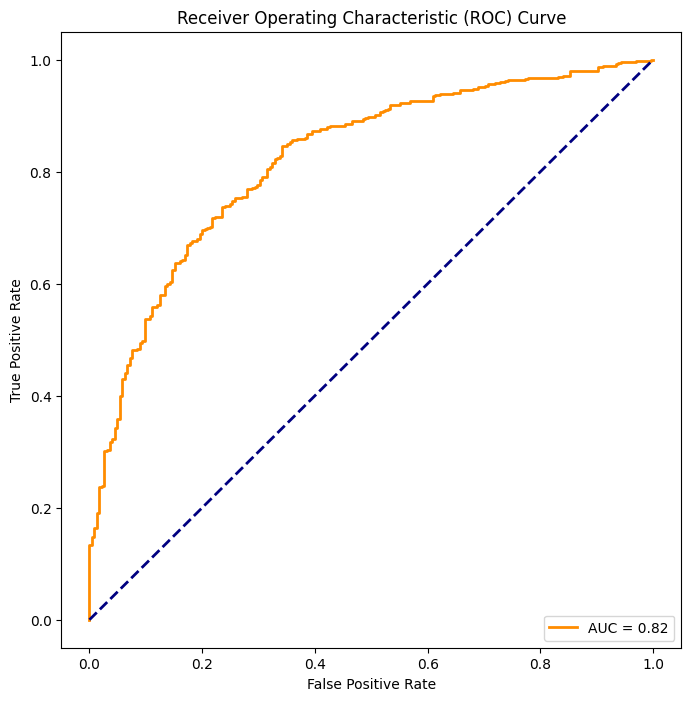

In [24]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = met.roc_curve(y_train, y_train_pred_proba)
roc_auc = met.auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

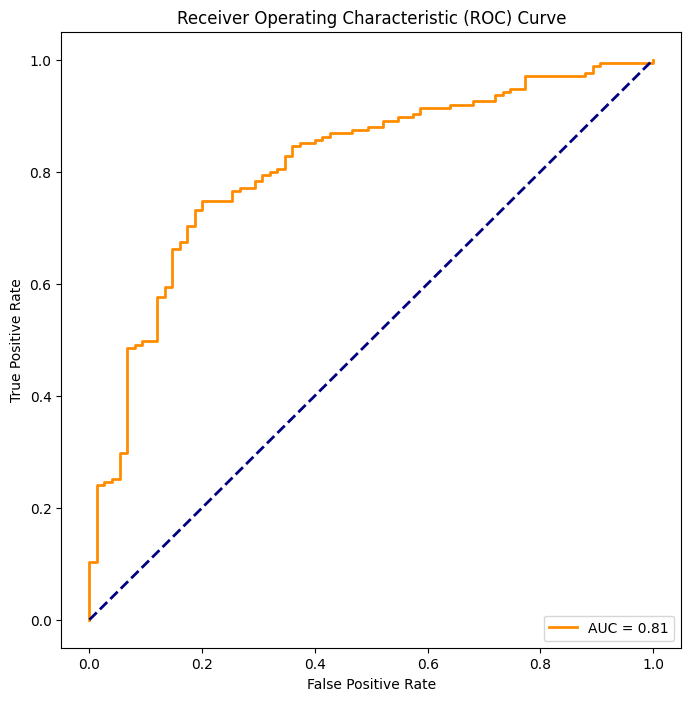

In [25]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = met.roc_curve(y_test, y_pred_proba)
roc_auc = met.auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [26]:
print('Average Cross-Validation Gini Score:', round(study.best_value * 2 - 1, 2))
print('Gini Score on test set:', round(roc_auc * 2 - 1, 2))

Average Cross-Validation Gini Score: 0.56
Gini Score on test set: 0.62


Model result


With proper hyperparameter tuning we could increase Gini score from 0.41 (baseline) to 0.62. This score indicates selected features are doing great job at explaining default probability of the given customers.

Note: Having higher score on test set compared to cross validation indicates we got lucky in train-test split. The observed ease of classification in the test set might be specific to that particular data partition. Thus, it is crucial to prioritize cross-validation results over a single test set to obtain a more robust and generalizable assessment of your model's performance across different data subsets.

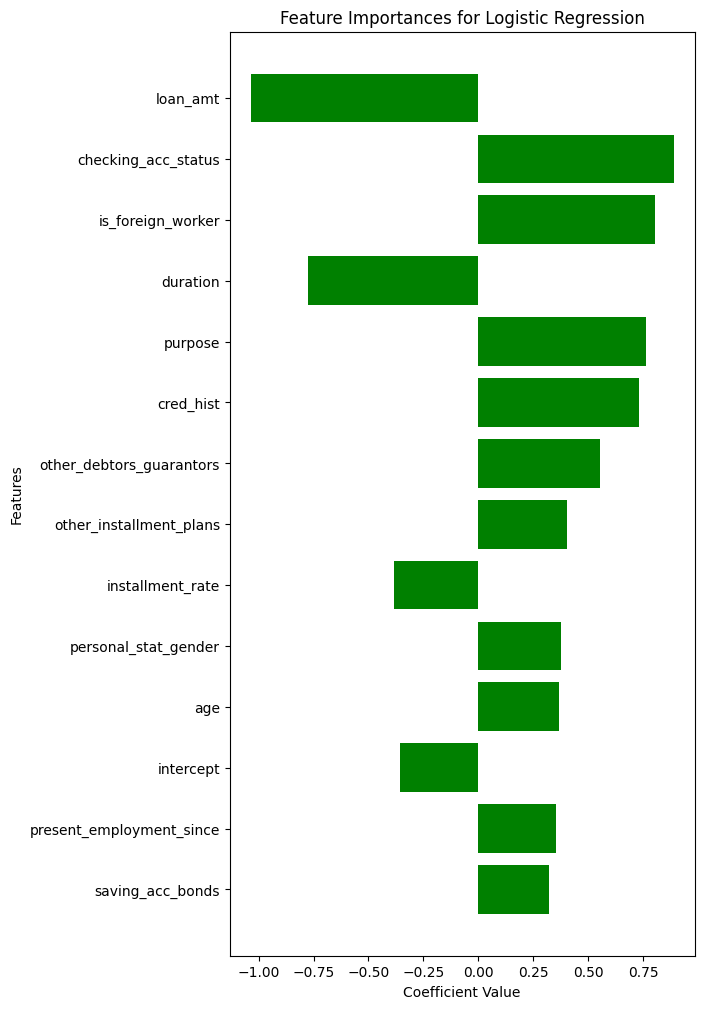

In [27]:
feature_importances = pipeline[-1].coef_[0]
feature_names = list(pipeline[:-1].transform(X_train).columns)
feature_names = ['_'.join(name.split('__')[1:]) for name in feature_names]
feature_names.append('intercept')

intercept = pipeline[-1].intercept_[0]
fimp = pd.DataFrame(list(feature_importances) + [intercept], index=feature_names, columns=['value']).reset_index()
fimp['significancy'] = fimp.value.abs()
fimp = fimp.sort_values('significancy', ascending=True)

plt.figure(figsize=(6,12))
plt.barh(fimp['index'], fimp['value'], color='green')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances for Logistic Regression')
plt.show()

In [28]:
fimp.shape

(14, 3)

In [29]:
fimp

,index,value,significancy
6,saving_acc_bonds,0.322401,0.322401
7,present_employment_since,0.352734,0.352734
13,intercept,-0.355579,0.355579
3,age,0.366474,0.366474
8,personal_stat_gender,0.377160,0.377160
2,installment_rate,-0.384965,0.384965
10,other_installment_plans,0.403620,0.403620
9,other_debtors_guarantors,0.553905,0.553905
5,cred_hist,0.732684,0.732684
12,purpose,0.765553,0.765553


In [30]:
feature_importances

array([-0.77628625, -1.03576382, -0.38496469,  0.36647354,  0.88913532,
        0.73268367,  0.32240105,  0.35273397,  0.37715961,  0.55390473,
        0.40361958,  0.80284793,  0.76555256])

In [31]:
intercept

-0.3555790248415744

In [32]:
y_pred = pipeline.predict(X_test)
print(met.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.73      0.65        75
           1       0.87      0.77      0.82       175

    accuracy                           0.76       250
   macro avg       0.72      0.75      0.73       250
weighted avg       0.78      0.76      0.77       250



In [33]:
from joblib import dump

dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']